<a href="https://colab.research.google.com/github/Nabiltchoulak/Robust-Classification-wuth-PD-algorithm/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import scipy
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys

# Modifier la variable du TD en fonction de l'endroit où les données sont stockées
TD_DIR = 'gdrive/My Drive/TD1/'
sys.path.append(TD_DIR)
#print(sys.path)
mat_contents = sio.loadmat(TD_DIR+"DrivFace.mat")

Mounted at /content/gdrive


In [4]:
# Load data
trainX=mat_contents['drivFaceD'][0,0][0]
y_init = mat_contents['drivFaceD'][0,0][2]
# Transform output encoding to one hot
trainY = np.zeros((y_init.size, y_init.max()))
trainY[np.arange(y_init.size),np.transpose(y_init-1)]=1


In [6]:
class PD_algorithm(object):
  def __init__(self,trainX,trainY,sigma,tho,alpha,l):
    self.trainX = trainX
    self.trainY = trainY
    self.k=trainY.shape[1]
    self.m = trainX.shape[0]
    self.d=trainX.shape[1]
    self.sigma = sigma
    self.tho = tho
    self.alpha = alpha
    self.l=int(l)
    
    self.U = np.ones((self.k,self.l))
   
    ############### Initialise W and M randomly
    self.W = np.random.randn(self.d,self.l)
    #self.W = np.random.rand(self.d,self.l,density=0.5)
    self.M = np.random.randn(self.k,self.l)
    
  def initiate_weights(self):
    pca = PCA(self.l)
    pca.fit(self.trainX.T)
    self.W = pca.transform(trainX.T)
    kmeans = KMeans(n_clusters=3).fit(np.dot(trainX,self.W))
    self.M = kmeans.cluster_centers_
    print(self.W.shape)
    print(self.M.shape)


  def soft_v(self,W,v):
    return np.multiply(np.sign(W),np.maximum(np.abs(W)-(v),0))
  def prox_g(self,W):
    return self.soft_v(W,(self.tho*self.alpha))

  def proj_C(self,M):
    seuil  = round(M.sum(),9)
    if seuil >= 1:
      return M
    else :
      return M + (1/(self.k*self.l))*(1-seuil)*self.U
      print("out")
      
  def prox_f(self,Z):
    return Z - self.sigma*self.soft_v((1/self.sigma)*Z,1/self.sigma)

  
  

  def train(self):
    cost = []
    
    #split train data for validation
    trainX, validX, trainY,validY = train_test_split(self.trainX, self.trainY, test_size=0.3)
    validY = [np.where(r==1)[0][0] for r in validY]
    v_n = np.ones((trainX.shape[0],self.l))
    # initiate validation parameters for cross validation
    V_min = np.zeros((self.k,1))
    W_min = np.ones_like(self.W)
    M_min = np.ones_like(self.M)
    n_min = 0
    z=0
    for n in range(1500):
        M_n = self.M
        W_n = self.W
        
        self.W = self.prox_g(W_n + self.tho*np.dot(np.transpose(trainX),v_n))
        self.M = self.proj_C(M_n - self.tho*np.dot(np.transpose(trainY),v_n))
        v_n = self.prox_f(v_n + self.sigma*(np.dot(trainY,(2*self.M - M_n)) - np.dot(trainX,2*self.W - W_n)))
        diff = np.sum(np.abs(np.dot(trainY,self.M) - np.dot(trainX,self.W)))
        loss = diff + alpha*np.sum(np.abs(self.W))
        cost.append(loss)
        if (n%50 == 0):
          # Check the state of the stoping criterions on the algorithm
          print("Iteration ", n, "loss :",diff)
          print("z = ",z)
          
          Y_v= self.predict(validX)
          
          C = confusion_matrix(validY,Y_v)
          print(C)
        # Stoping criteria 
        # 1-> test the degree of sparsity in W
        #2-> estimate the validation score 
        # 3 -> if Score minimal take W as W_min
        z= np.count_nonzero(self.W==0)/(self.W.size)
        if (z>0.3):# add AND condition to ensure early stoping choice 
          Y_v= self.predict(validX)
          # We add +1 to synchronise classes from [0-2] to [1-3]
          C = confusion_matrix(validY,
                             Y_v)
          V = np.array([C[i,i]/C[i].sum(axis=0) for i in range(self.k)])# validation 
          if ((V>=V_min).all()):
            V_min = V
            W_min = self.W
            M_min = self.M
            n_min = n # keep the iteration where we saved the minimum value
          if (n - n_min) == 50:
            print("best score at ", n_min, "iterations")
            break
            
    self.W = W_min
    self.M= M_min          
    return cost
  def predict(self,testX):
    Y_p = np.transpose(distance.cdist(np.dot(testX,self.W),self.M).argmin(axis=1) ) 
    return Y_p
  


Iteration  0 loss : 17843172.16241726
z =  0
[[  0   0   8]
 [  0   0 162]
 [  0   0  12]]
Iteration  50 loss : 1277312.0386116356
z =  0.011054375
[[  2   4   2]
 [  2 160   0]
 [  0   8   4]]
Iteration  100 loss : 951222.9929673836
z =  0.0260275
[[  0   7   1]
 [  0 162   0]
 [  1   5   6]]
Iteration  150 loss : 863056.4483540391
z =  0.04498875
[[  3   5   0]
 [  0 162   0]
 [  0   6   6]]
Iteration  200 loss : 771342.4218738251
z =  0.06501875
[[  5   3   0]
 [  0 161   1]
 [  0   7   5]]
Iteration  250 loss : 658148.5621080765
z =  0.0852353125
[[  5   3   0]
 [  0 161   1]
 [  0   8   4]]
Iteration  300 loss : 616689.7242097817
z =  0.107118125
[[  4   4   0]
 [  0 161   1]
 [  1   5   6]]
Iteration  350 loss : 559373.0931372804
z =  0.1288284375
[[  5   3   0]
 [  0 161   1]
 [  1   3   8]]
Iteration  400 loss : 505789.31834418536
z =  0.14949875
[[  5   3   0]
 [  0 161   1]
 [  1   3   8]]
Iteration  450 loss : 473723.78763563366
z =  0.17085
[[  5   3   0]
 [  0 161   1]
 [ 

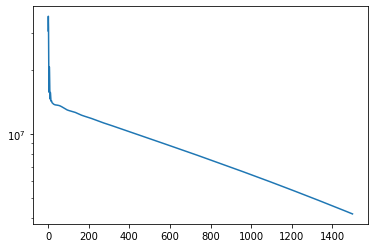

In [7]:
# Parameters of the training algorithm
alpha = 5 
tho = 0.0001
sigma = 0.004
l = 500
model = PD_algorithm(trainX,
                     trainY,
                     alpha=alpha,
                     tho=tho,
                     sigma=sigma,
                     l=l)
model.initiate_weights
cost = model.train()
plt.yscale("log")
plt.plot(cost)


In [ ]:
# Prediction on test data

Y_p=model.predict(trainX)
# We add +1 to synchronise classes from [0-2] to [1-3]
C = confusion_matrix(y_init, 
                     Y_p+1)
print(C)

In [ ]:
import shutil
import os
split_dir='  '
split_file = os.path.join(split_dir, 'test.csv')
with open(split_file, 'r') as f:
    split = [x.strip().split(',') for x in f.readlines()[1:] if x.strip() != '']
names=[x[0] for x in split]
images_dir= ' '
dist_dir=' '
for name in names :
  shutil.copy2(images_dir+name, dist_dir) # complete target filename given
